<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/main/AML_IceCores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set

Streaming output truncated to the last 5000 lines.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5504.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5505.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5506.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5507.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5508.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5509.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_551.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5510.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5511.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5512.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5513.png  
  inflating: Insoluables_T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = sup.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [6]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    x_train.append(sup.__getitem__(rand_idx[i])[0])
x_train = np.array(x_train)

In [7]:
x_train.shape

(10000, 128, 128)

In [8]:
latent_dim = 128
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 128)               7872640   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1
282/282 [==============================] - 20s 32ms/step - loss: 0.0366 - val_loss: 0.0116


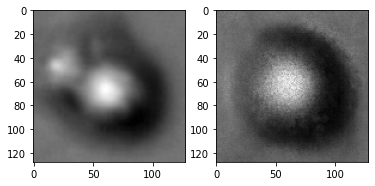

2
282/282 [==============================] - 9s 32ms/step - loss: 0.0087 - val_loss: 0.0064


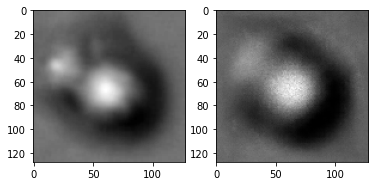

3
282/282 [==============================] - 9s 32ms/step - loss: 0.0057 - val_loss: 0.0049


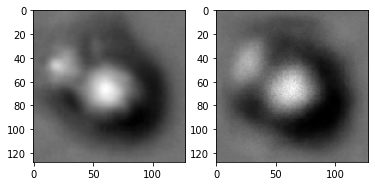

4
282/282 [==============================] - 10s 34ms/step - loss: 0.0044 - val_loss: 0.0041


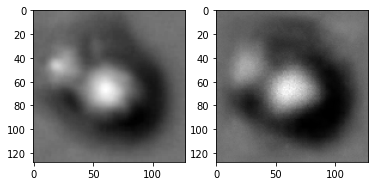

5
282/282 [==============================] - 9s 33ms/step - loss: 0.0037 - val_loss: 0.0035


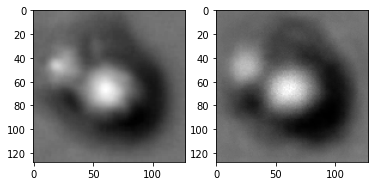

6
282/282 [==============================] - 9s 33ms/step - loss: 0.0032 - val_loss: 0.0032


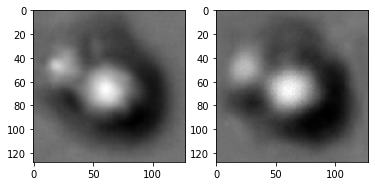

7
282/282 [==============================] - 10s 34ms/step - loss: 0.0029 - val_loss: 0.0028


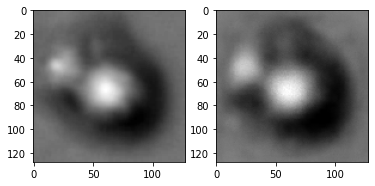

8
282/282 [==============================] - 10s 36ms/step - loss: 0.0025 - val_loss: 0.0024


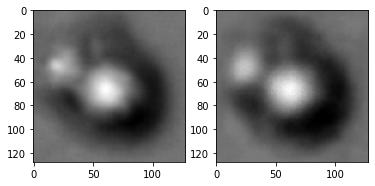

9
282/282 [==============================] - 9s 33ms/step - loss: 0.0023 - val_loss: 0.0022


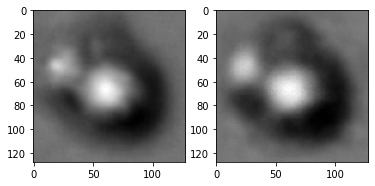

10
282/282 [==============================] - 10s 34ms/step - loss: 0.0021 - val_loss: 0.0027


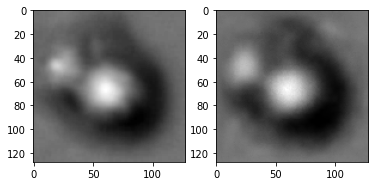

11
282/282 [==============================] - 9s 34ms/step - loss: 0.0021 - val_loss: 0.0019


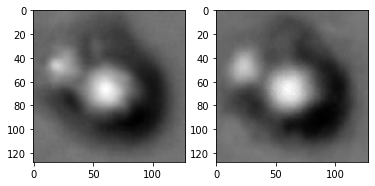

12
282/282 [==============================] - 9s 33ms/step - loss: 0.0018 - val_loss: 0.0019


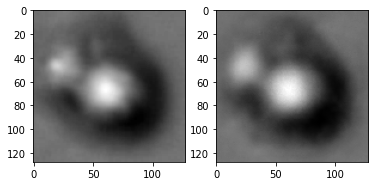

13
282/282 [==============================] - 9s 33ms/step - loss: 0.0017 - val_loss: 0.0020


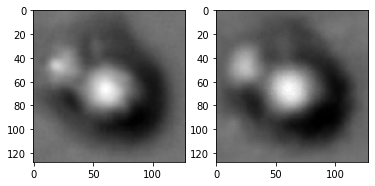

14
282/282 [==============================] - 9s 33ms/step - loss: 0.0017 - val_loss: 0.0017


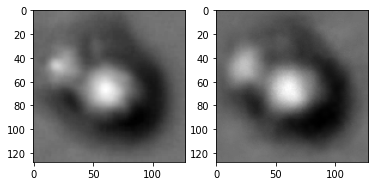

15
282/282 [==============================] - 9s 34ms/step - loss: 0.0015 - val_loss: 0.0018


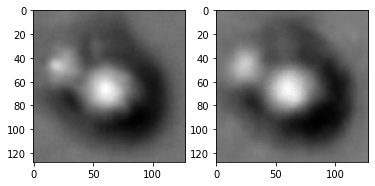

16
282/282 [==============================] - 9s 34ms/step - loss: 0.0016 - val_loss: 0.0017


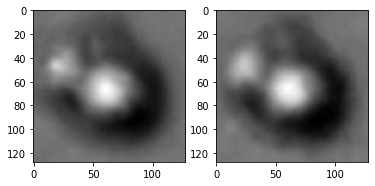

17
282/282 [==============================] - 10s 34ms/step - loss: 0.0015 - val_loss: 0.0017


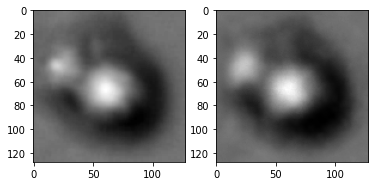

18
282/282 [==============================] - 9s 34ms/step - loss: 0.0014 - val_loss: 0.0019


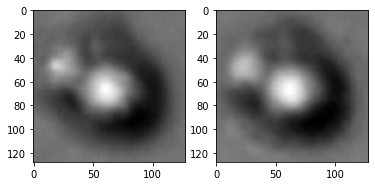

19
282/282 [==============================] - 9s 34ms/step - loss: 0.0020 - val_loss: 0.0016


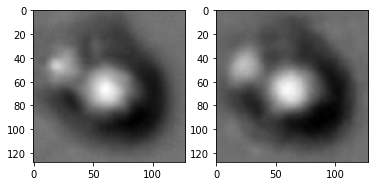

20
282/282 [==============================] - 9s 34ms/step - loss: 0.0013 - val_loss: 0.0016


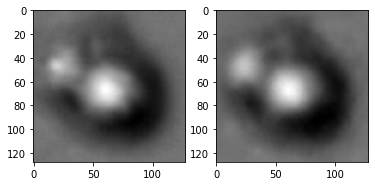

21
282/282 [==============================] - 9s 34ms/step - loss: 0.0013 - val_loss: 0.0018


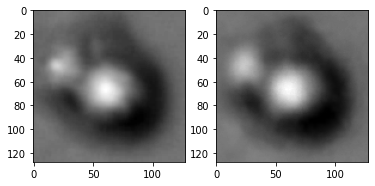

22
282/282 [==============================] - 9s 33ms/step - loss: 0.0013 - val_loss: 0.0017


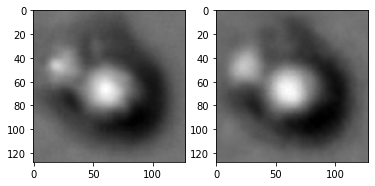

23
282/282 [==============================] - 10s 35ms/step - loss: 0.0013 - val_loss: 0.0016


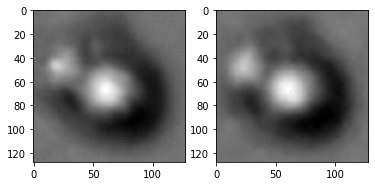

24
282/282 [==============================] - 10s 35ms/step - loss: 0.0012 - val_loss: 0.0016


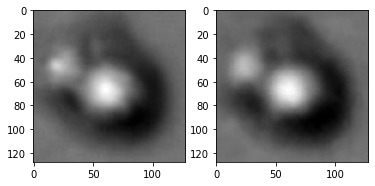

25
282/282 [==============================] - 10s 35ms/step - loss: 0.0012 - val_loss: 0.0015


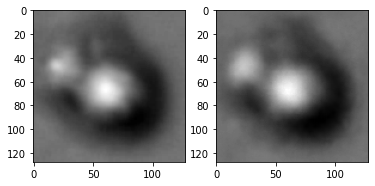

26
282/282 [==============================] - 10s 34ms/step - loss: 0.0012 - val_loss: 0.0016


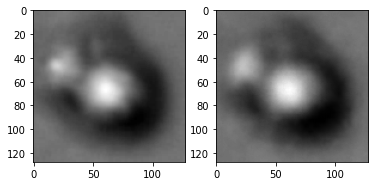

27
282/282 [==============================] - 10s 35ms/step - loss: 0.0011 - val_loss: 0.0015


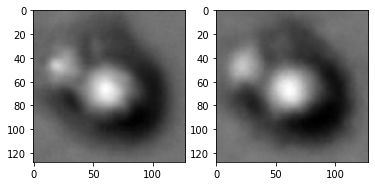

28
282/282 [==============================] - 10s 35ms/step - loss: 0.0012 - val_loss: 0.0016


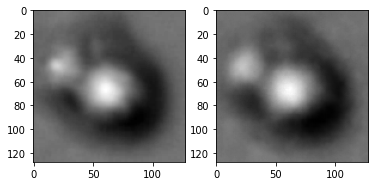

29
282/282 [==============================] - 10s 35ms/step - loss: 0.0011 - val_loss: 0.0016


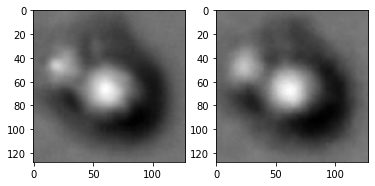

30
282/282 [==============================] - 10s 35ms/step - loss: 0.0011 - val_loss: 0.0016


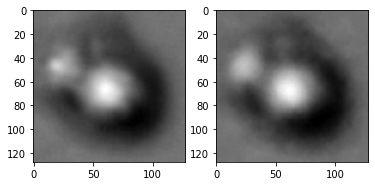

In [9]:
for i in range(30):
  print(i+1)
  autoencoder.fit(x_train, x_train, epochs=1, batch_size=32, validation_split=0.1)
  test_im = sup.__getitem__(3000)[0]
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(test_im,cmap='gray')
  plt.subplot(1,2,2)
  im_pred = autoencoder.predict(test_im.reshape(-1,image_size,image_size,1)).reshape(128,128)
  plt.imshow(im_pred,cmap='gray')
  plt.show()